<a href="https://colab.research.google.com/github/deckerkrogh/semeval-2024-10/blob/main/semeval_emotion_classification_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Definitions and preliminaries:

**Emotion flip**: An emotion flip occurs at an utterance when its emotion tag is different from the emotion tag of the previous utterance. For example:

> 0: "Hey, Mon." (neutral) (trigger: no)

> 1: "Hey-hey-hey. You wanna hear something that sucks." (neutral) (trigger: yes)

> 2:  "Do I ever." (joy) (trigger: no)

There is an emotion flip at utterance 2 from neutral to joy.

**Emotion Trigger**: An emotion trigger is a tag applied to an utterance which "triggers" the emotion emotion. In the above example utterance 1 is tagged as a trigger because it is what causes the emotion of the other speaker to flip to joy. Every emotion flip has at least one trigger.

**Data**: The provided SemEval training data contains conversations from the show *Friends* which has been tagged with emotion flips and emotion triggers. The data is organized into "episodes" where every episode introduces one new emotion flip. The same utterances, coming from the same conversation, can be repeated between episodes. For example this is one of the other episodes in the training data:

> 0: "Hey, Mon." (neutral) (trigger: no)

> 1: "Hey-hey-hey. You wanna hear something that sucks." (neutral) (trigger: no)

> 2:  "Do I ever." (joy) (trigger: no)

> 3: "Chris says they're closing down the bar." (sadness) (trigger: **yes**)

> 4: "No way!" (suprise) (trigger: no)

> 5: "Yeah, apparently they're turning it into some kinda coffee place." (neutral) (trigger: **yes**)

> 6: "Just coffee! Where are we gonna hang out now?" (disgust) (trigger: **yes**)

> 7: "Got me." (sadness)

There are three utterances in this example (at 3, 5, and 6) which trigger the emotion flip to sadness at utterance 7.

## Tasks

**ERC Task**: Given a dialogue, the goal of Emotional Recognition in Conversation (ERC) is to assign each utterance an emotion.

**EFR Task**: Given a dialogue, the goal of Emotional Flip Reasoning (EFR) is to predict the triggers for the emotion flips in a sequence of utterances.

**Data Preprocessing:**



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
#from google.colab import drive

In [2]:
#drive.mount('/content/drive')

# Publicly hosted SemEval data:
url = 'https://raw.githubusercontent.com/deckerkrogh/nlp243_data/main/MELD_train_efr.json'
#file_path = '/content/drive/MyDrive/NLP243/MELD_train_efr.json'
#with open(file_path, 'r') as file:
#data = json.load(url)
raw_data = pd.read_json(url)

In [3]:
train_df = pd.DataFrame()

for i, episode in raw_data.iterrows():

    # Get the last emotion flip (this is the emotion flip which the
    # triggers refer to)
    #e_1 = episode['emotions'][0]
    #last_flip_i = 0
    #for i, e_2 in enumerate(episode['emotions'][1:]):
        #if e_1 != e_2:
            #last_flip_i = i + 1
        #e_1 = e_2

    episode_df = pd.DataFrame({
        'utterance': episode['utterances'],
        'emotions': episode['emotions']
        #'triggers': episode['triggers'],
        #'emotion_flip': last_flip_i
    })
    train_df = pd.concat([train_df, episode_df], ignore_index=True)

array([<Axes: title={'center': 'count'}, xlabel='emotions'>], dtype=object)

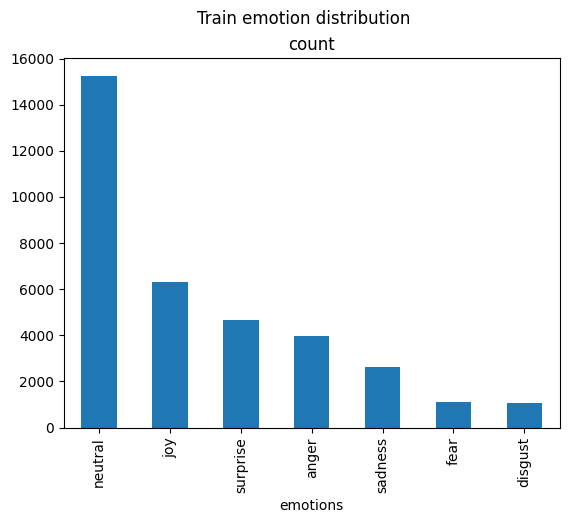

In [5]:
# TODO: remove duplicate utterances (which are numerous).
# I hypothesize that neutral is overrepresented because conversations will usually
#    start with neutral.
train_df['emotions'].value_counts().plot(title='Train emotion distribution', kind='bar', subplots=True)

In [ ]:
train_df['emotions'].unique()

In [6]:
train_df = train_df.dropna(subset=['emotions'])

X = train_df['utterance']
y = train_df['emotions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Vectorize utterances
vectorizer = TfidfVectorizer(max_features=1000)
X_train_feat = vectorizer.fit_transform(X_train)
X_test_feat = vectorizer.transform(X_test)


def run_linear_regression(X_train_feat, X_test_feat, y_train, y_test):
    # Binarize labels
    lb = LabelBinarizer()
    y_train_bin = lb.fit_transform(y_train)
    y_test_bin = lb.transform(y_test)

    lin_model = LinearRegression()
    lin_model.fit(X_train_feat, y_train_bin)

    # Calculate "probabilities" and set the highest to 1
    y_prob = lin_model.predict(X_test_feat)
    y_pred = (y_prob == y_prob.max(axis=1, keepdims=1)).astype(int)

    print("Linear Regression:")
    mse = mean_squared_error(y_test_bin, y_pred)
    print("Mean Squared Error: ", mse)
    accuracy = accuracy_score(y_test_bin, y_pred)
    print("Accuracy: ", accuracy)


def run_gaussianNB(X_train_feat, X_test_feat, y_train, y_test):
    # Encode the labels (assign an integer value)
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.fit_transform(y_test)

    nb_model = GaussianNB()
    nb_model.fit(X_train_feat.toarray(), y_train_encoded)

    y_pred = nb_model.predict(X_test_feat.toarray())

    print("\nGaussianNB:")
    mse = mean_squared_error(y_test_encoded, y_pred)
    print("Mean Squared Error: ", mse)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print("Accuracy: ", accuracy)

run_linear_regression(X_train_feat, X_test_feat, y_train, y_test)
#run_gaussianNB(X_train_feat, X_test_feat, y_train, y_test)

Linear Regression:
Mean Squared Error:  0.11277551020408165
Accuracy:  0.6052857142857143

GaussianNB:
Mean Squared Error:  5.764714285714286
Accuracy:  0.21142857142857144
